In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MultiLabelBinarizer
import tqdm
import csv
import random
from sklearn.decomposition import PCA
import pyreadr
import gensim 

%config IPCompleter.greedy=True

In [2]:
DIRECTORY = '/Users/diyahirc/Documents/BCM/genesets' # Change to your path
MINSETSIZE = 2

In [3]:
geneSetList = []

for fileName in os.listdir(DIRECTORY):
    tempList = []
    tempPath = os.path.join(DIRECTORY, fileName)
    tempFile = open(tempPath,'r')
    print(tempPath)
    
    tempLines = tempFile.readlines()
    count = 0
    for line in tempLines:
        line = line.upper()
        line = line.strip('\n') 
        tempGeneSet = line.split('\t')[2:] # first two entries are 'geneSet name' and 'discription'   
        if len(tempGeneSet) >= MINSETSIZE:           # not interested in single gene'd gene sets
            geneSetList.append(set(tempGeneSet))

/Users/diyahirc/Documents/BCM/genesets/hsapiens_pathway_Wikipathway_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_pathway_Reactome_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_geneontology_Cellular_Component_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/pathway25y.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_pathway_Panther_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_network_CORUM_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_geneontology_Biological_Process_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_geneontology_Molecular_Function_genesymbol.gmt
/Users/diyahirc/Documents/BCM/genesets/hsapiens_pathway_KEGG_genesymbol.gmt


In [96]:
from gensim.models import KeyedVectors

MODELPATH = "/Users/diyahirc/Files/BCM/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_60.model"
geneModel = KeyedVectors.load(MODELPATH)

# gene2vecMODELPATH = "/Users/diyahirc/Files/BCM/gen2vec/Gene2vec/pre_trained_emb/gene2vec_dim_200_iter_9_w2v.txt"
# geneModel = gensim.models.KeyedVectors.load_word2vec_format(gene2vecMODELPATH)

In [12]:
caps = pd.read_csv('pfocr_captions.csv')
caps.head()

,Unnamed: 0,caption,genes
0,PMC5653847__41598_2017_14124_Fig8_HTML.jpg,Model of FTY720-induced transporter endocytosi...,"{'ARRESTIN', 'RSP5', 'mTORC1', 'TORC1'}"
1,PMC4187043__zh20191474070013.jpg,Proposed signaling pathway by which the stimul...,"{'PDE3', 'PLC', 'PKA', 'AT2', 'PKC', 'PTK', 'A..."
2,PMC5746550__rsob-7-170228-g1.jpg,Aβ production. In the amyloidogenic pathway (r...,"{'CSE-C', 'ASS'}"
3,PMC4211692__pone.0110875.g008.jpg,Glucolipotoxicity impairs CERT- and vesicular-...,"{'CERT', 'CERS4', 'AKT'}"
4,PMC2588433__nihms78212f8.jpg,Bacterial Sia biosynthesis can be divided into...,"{'CMP', 'NEU'}"


In [97]:
setsInVocab = []
MINLENGTH = 10
for index in range(len(geneSetList)):
        geneSet = geneSetList[index]
#         if len(geneSet) == 14:
        allContainedFlag = 1 # make sure all the genes in the test set are in the vocab
        for gene in geneSet:
            if gene not in geneModel.wv.vocab:
                allContainedFlag = 0
        if allContainedFlag:
            if len(geneSet) > MINLENGTH:
                setsInVocab.append(geneSet)
                testSet = geneSet
#             print(geneSet)
#             asdas
print('Number of Genes in Emb  = {vocablen}'.format(vocablen=len(geneModel.wv.vocab)))
print('Number of sets in vocab = {setInVcab}'.format(setInVcab = len(setsInVocab)))

Number of Genes in Emb  = 12254
Number of sets in vocab = 33740


DescribeResult(nobs=33740, minmax=(11, 282), mean=28.988589211618258, variance=387.69532608691634, skewness=2.463066031054962, kurtosis=10.267959045131198)


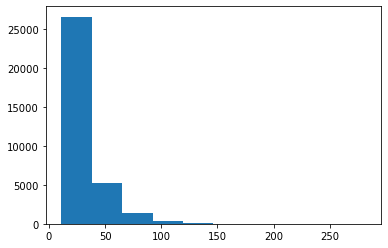

In [98]:
setLens = [len(geneSet) for geneSet in setsInVocab]
print(stats.describe(setLens))
plt.hist(setLens)
plt.show()

In [100]:
def geneEmbDistance(gene1:str,gene2:str) -> float:
    tempVec1 = geneModel.wv[gene1]
    tempVec2 = geneModel.wv[gene2]
    
    dist = np.linalg.norm(tempVec1-tempVec2)
    
    return dist

def getAvgVecSet(geneSet:set):
    avgVec = np.zeros(200)
    
    for gene in geneSet:
        avgVec += geneModel.wv[gene]
        
    return avgVec/len(geneSet)

def geneSetDistance(geneSet1:set,geneSet2:set,distanceFun):
    
    size1 = len(geneSet1)
    size2 = len(geneSet2)
    
    if size1 == 0 or size2 == 0:
        return 'Error'    
    distance = 0
    
    for myGene in geneSet1:
        tempDistance = 0
        
        if myGene not in geneSet2:
            avgVec = getAvgVecSet(geneSet2)
            
            tempVec = geneModel.wv[myGene]
            tempDist = np.linalg.norm(tempVec-avgVec)
#             for dbGene in geneSet2:
#                 tempDistance += distanceFun(myGene,dbGene)
#             tempDistance = tempDistance # avg distance between current gene and all genes in comp GS
            distance += tempDist
            
    return distance/size1 # Normalizing by size 

def getGeneSetDistance(geneSet1:set,geneSet2:set,distanceFun):
    return 0.5*(geneSetDistance(geneSet1,geneSet2,distanceFun) + geneSetDistance(geneSet2,geneSet1,distanceFun))

In [102]:
testSet =  random.choice(setsInVocab)
print(testSet)
print(len(testSet))


{'HSPG2', 'HPSE2', 'SGSH', 'IDS', 'GUSB', 'GLB1', 'SDC4', 'IDUA', 'GPC1', 'GPC5', 'NAGLU', 'AGRN', 'SDC2', 'HGSNAT', 'GLB1L', 'SDC3', 'HPSE', 'GPC6', 'GPC3', 'GPC2', 'SDC1', 'GPC4'}
22


In [103]:
from itertools import combinations  

comb = combinations(testSet, len(testSet)-1)  
removeOneDists = []
# Print the obtained combinations  
for perm in list(comb):  
    removeOneDists.append(getGeneSetDistance(perm,testSet,geneEmbDistance))
    
comb = combinations(testSet, len(testSet)-3)  
addRandGeneDists = []
for perm in list(comb):
    randGene = random.choice(list(geneModel.wv.vocab.keys()))
    perm = list(perm)
    perm.append(randGene)
    addRandGeneDists.append(getGeneSetDistance(perm,testSet,geneEmbDistance))

comb = combinations(testSet, len(testSet)-2)  
remove2Dists = []
# Print the obtained combinations  
for perm in list(comb):  
    remove2Dists.append(getGeneSetDistance(perm,testSet,geneEmbDistance))
    
comb = combinations(testSet, len(testSet)-3)  
remove3Dists = []
# Print the obtained combinations  
for perm in list(comb):  
    remove3Dists.append(getGeneSetDistance(perm,testSet,geneEmbDistance))

randGenesDists = []
for i in range(10):
#     print(i)
    tempSet = set()
    for ind in range(len(testSet)):
        randGene = random.choice(list(geneModel.wv.vocab.keys()))
#         print(randGene)
        tempSet.add(randGene)
#     print(tempSet)
    randGenesDists.append(getGeneSetDistance(tempSet,testSet,geneEmbDistance))
print('Done!')

Done!


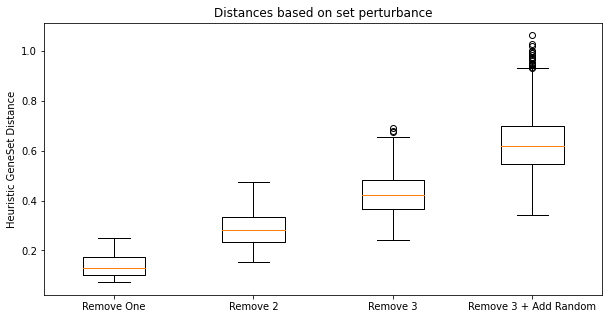

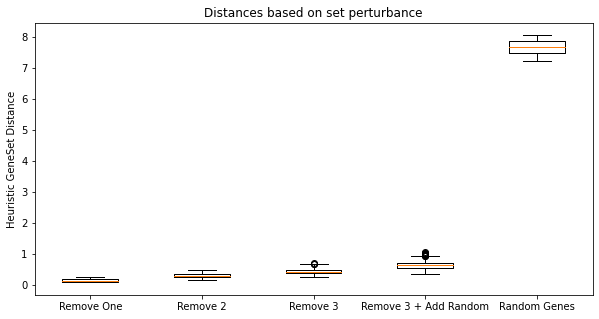

In [104]:
plt.figure(figsize=(10,5))

plt.boxplot([removeOneDists,remove2Dists,remove3Dists,addRandGeneDists])
plt.ylabel('Heuristic GeneSet Distance')
plt.title('Distances based on set perturbance')
plt.xticks([1,2,3,4],['Remove One','Remove 2','Remove 3','Remove 3 + Add Random'])
plt.show()

plt.figure(figsize=(10,5))

plt.boxplot([removeOneDists,remove2Dists,remove3Dists,addRandGeneDists,randGenesDists])
plt.ylabel('Heuristic GeneSet Distance')
plt.title('Distances based on set perturbance')
plt.xticks([1,2,3,4,5],['Remove One','Remove 2','Remove 3','Remove 3 + Add Random','Random Genes'])
plt.show()

In [105]:
testSet =  random.choice(setsInVocab)
print(testSet)
print(len(testSet))


{'TRAF5', 'JUND', 'TRAF6', 'IRAK1', 'NR2C2', 'IL18', 'TLR5', 'MYD88', 'FOSL2', 'IL1R1', 'TLR6', 'IRAK4', 'MKKS', 'CXCL8', 'JUN', 'NFKB1', 'IRF6', 'JUNB', 'TLR4', 'IL6', 'TAB2', 'TNFRSF1B', 'TAB1', 'FOS', 'TNF', 'TRAF2', 'FOSB', 'TLR2', 'FOSL1'}
29


In [112]:
def getPValue(sampleSet:set,functionalSet:set):
    [M, n, N] = [24447, len(functionalSet), len(sampleSet)]
    rv = hypergeom(M, n, N)
    x = np.arange(0, n+1)
    pmfgenes = rv.pmf(x)
    
    interSet = sampleSet.intersection(functionalSet)
    
    cdf = []
    for ind in range(len(pmfgenes)):
        cdf.append(np.sum(pmfgenes[ind+1:]))
        
    return cdf[len(interSet)]


def getInterSectPercentage(set1:set,set2:set):
    percentIntersection = len(set1.intersection(set2))/len(set1.union(set2))
    return percentIntersection
    
    

In [107]:
distancesFromTest = [getGeneSetDistance(tempSet,testSet,geneEmbDistance) for tempSet in tqdm.tqdm(setsInVocab)]

100%|██████████| 33740/33740 [03:16<00:00, 171.94it/s]


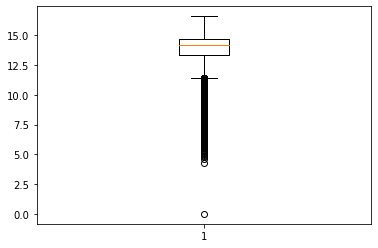

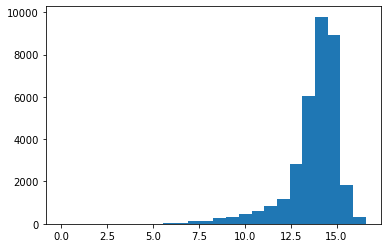

DescribeResult(nobs=33740, minmax=(0.0, 16.587587830595385), mean=13.777857444571243, variance=2.116693055064177, skewness=-2.0416295865228, kurtosis=5.701574623564754)


In [108]:
plt.boxplot(distancesFromTest)
plt.show()
plt.hist(distancesFromTest,bins=24)
plt.show()
print(stats.describe(distancesFromTest))

In [116]:
setsWithDists = [ [setsInVocab[ind],distancesFromTest[ind], getInterSectPercentage(testSet,setsInVocab[ind]),getPValue(testSet,setsInVocab[ind])] for ind in tqdm.tqdm(range(len(setsInVocab)))]

setsWithDists.sort(key = lambda x: x[1]) 

100%|██████████| 33740/33740 [00:30<00:00, 1093.97it/s]


In [120]:
dists = [ x[1] for x in setsWithDists]
pvals =  [ np.log(x[3]) for x in setsWithDists]
setInters =  [ x[2] for x in setsWithDists]

<ipython-input-120-44675f83939a>:2: RuntimeWarning: divide by zero encountered in log
  pvals =  [ np.log(x[3]) for x in setsWithDists]


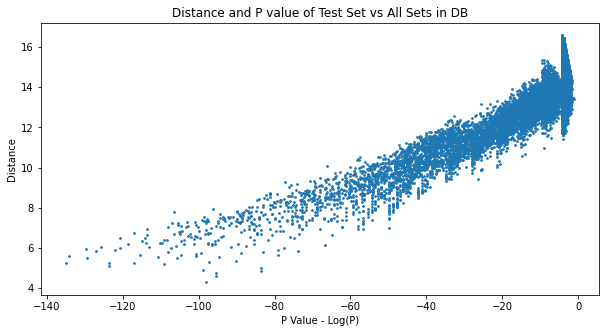

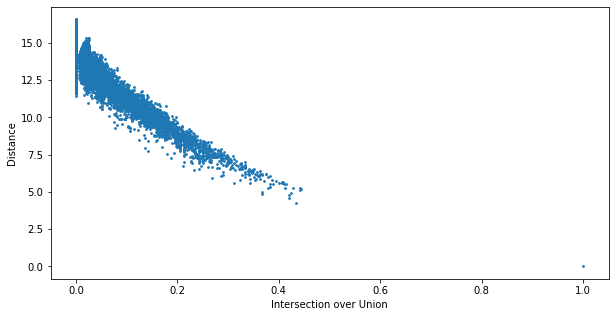

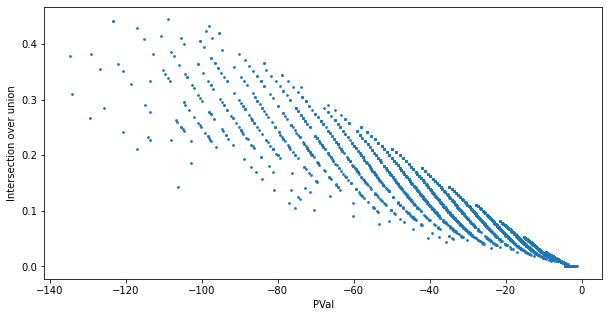

In [122]:
# print(distVsIntersec)
plt.figure(figsize=(10,5))

plt.scatter(pvals,dists,s=3)
plt.title('Distance and P value of Test Set vs All Sets in DB')
plt.ylabel('Distance')
plt.xlabel('P Value - Log(P)')
plt.show()

plt.figure(figsize=(10,5))

plt.scatter(setInters,dists,s=3)
plt.ylabel('Distance')
plt.xlabel('Intersection over Union')
plt.show()

plt.figure(figsize=(10,5))

plt.scatter(pvals,setInters,s=3)
plt.ylabel('Intersection over union')
plt.xlabel('PVal')
plt.show()